In [274]:
# ! pip install torch torchvision

In [275]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt

%matplotlib inline

In [276]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

dataset = MNIST(root="./data", download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

In [277]:
image, label = dataset[0]
image.shape # the dims represent color channel, width and height

torch.Size([1, 28, 28])

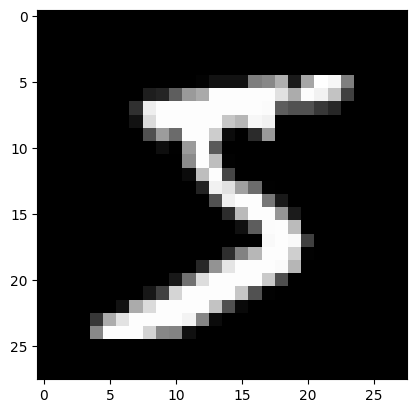

In [278]:
plt.imshow(image.permute(1, 2, 0), cmap='gray')

In [279]:
label

5

In [280]:
len(dataset), len(testset)

(60000, 10000)

In [281]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [282]:
val_data_size = 10000
train_data_size = len(dataset) - val_data_size

train_ds, val_ds = random_split(dataset, [train_data_size, val_data_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [283]:
batch_size = 128

In [284]:
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(testset, shuffle=False, num_workers=os.cpu_count())

In [285]:
class MNISTModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.l1 = nn.Linear(in_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.l1(x)
        out = F.relu(out)
        out = self.l2(out)
        return out


In [286]:
input_size = 784
hidden_size = 32
num_classes = 10

In [287]:
model = MNISTModel(in_size=input_size, hidden_size=hidden_size, out_size=num_classes)

In [288]:
loss_fn = nn.CrossEntropyLoss()
# https://paperswithcode.com/method/sgd-with-momentum
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [289]:
def train(dataloader, model, loss_fn, optimizer):
    
    # Total size of dataset for reference
    size = 0
    
    # places your model into training mode
    model.train()
    
    # loss batch
    batch_loss = {}
    batch_accuracy = {}
    
    correct = 0
    _correct = 0
    
    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):
        
        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)
        
        # Compute prediction error / loss
        # 1. Compute y_pred 
        # 2. Compute loss between y and y_pred using selectd loss function
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0 
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
        _batch_size = len(X)
        
        correct += _correct
        
        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size
        
        size += _batch_size
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")
    
    correct/=size
    print(f"Train Accuracy: {(100*correct)}%")
    
    return batch_loss , batch_accuracy

In [290]:
def validation(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with torch.no_grad():
        
        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            
            _correct = (pred.argmax(dim=1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size
    
    ## Calculating loss based on loss function defined
    test_loss /= num_batches
    
    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss}% \n")
    
    return batch_loss , batch_accuracy

In [291]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = validation(valid_dataloader, model, loss_fn)
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))     
    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))     
print("Done!")

Epoch 1
-------------------------------
loss: 2.344489  [    0]
loss: 1.628528  [12800]
loss: 1.137532  [25600]
loss: 0.798369  [38400]
Train Accuracy: 67.714%
Valid Error: 
 Accuracy: 83.73%, Avg loss: 0.670181817646268% 

Epoch 2
-------------------------------
loss: 0.639045  [    0]
loss: 0.588852  [12800]
loss: 0.452845  [25600]
loss: 0.433979  [38400]
Train Accuracy: 86.284%
Valid Error: 
 Accuracy: 87.16000000000001%, Avg loss: 0.4612085110024561% 

Epoch 3
-------------------------------
loss: 0.484256  [    0]
loss: 0.405704  [12800]
loss: 0.342660  [25600]
loss: 0.341568  [38400]
Train Accuracy: 88.422%
Valid Error: 
 Accuracy: 88.59%, Avg loss: 0.39963983716089513% 

Epoch 4
-------------------------------
loss: 0.383258  [    0]
loss: 0.439426  [12800]
loss: 0.410186  [25600]
loss: 0.345348  [38400]
Train Accuracy: 89.426%
Valid Error: 
 Accuracy: 89.32%, Avg loss: 0.3682589366843429% 

Epoch 5
-------------------------------
loss: 0.353316  [    0]
loss: 0.294713  [12800]


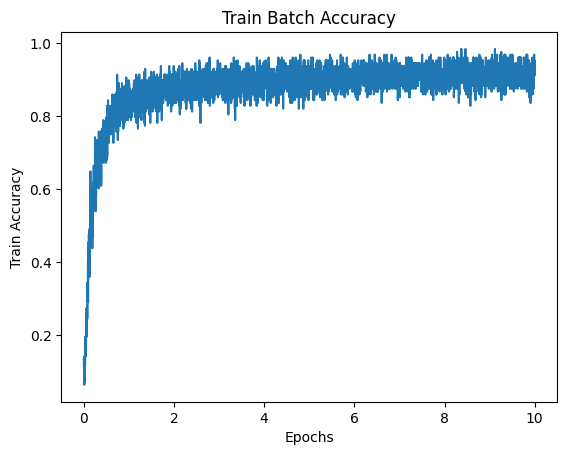

In [292]:

plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

plt.show()


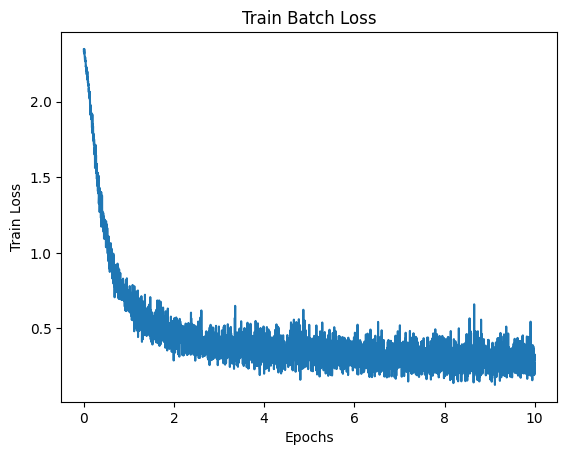

In [293]:
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 

plt.show()

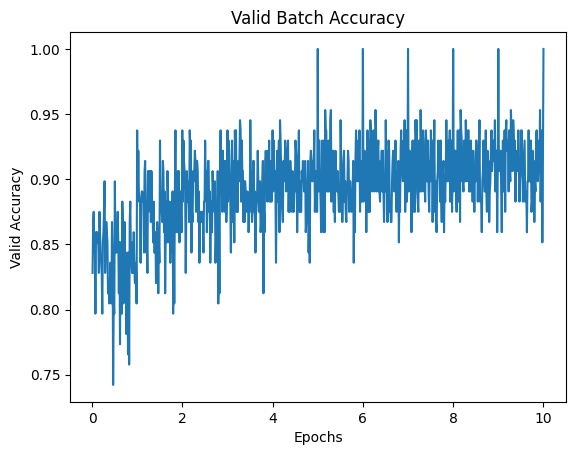

In [294]:
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Valid Accuracy") 
plt.show()



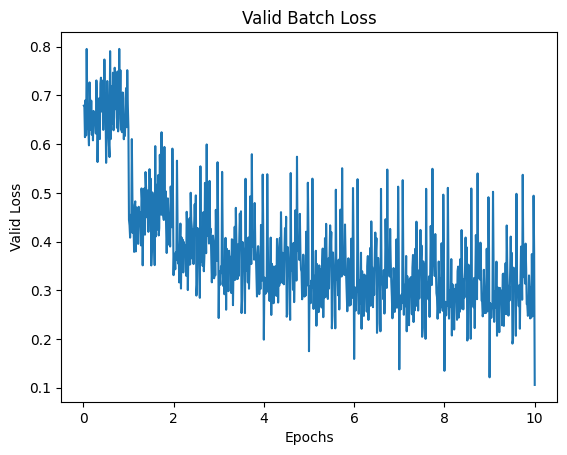

In [295]:
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Valid Loss")
plt.show()

In [296]:
test_loss , test_accuracy = validation(test_dataloader, model, loss_fn)

Valid Error: 
 Accuracy: 92.02%, Avg loss: 0.2824554007455258% 

